Use the simple SNR model from "Design considerations for low-margin elastic optical networks in the nonlinear regime" Savory et al. with an added white Gaussian noise term, designed to alleviate the problem of significantly reducing the predictive variance of the model:
$SNR = \frac{P}{a + bP^3} + cN(0, \sigma)$


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from scipy.optimize import minimize
from numpy.random import normal
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [29]:
data_dir = '/Users/joshnevin/Desktop/JavierBERdata/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)[21:60]
# snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam300.csv", "r"), delimiter=",", dtype =float)
# pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam300.csv", "r"), delimiter=",", dtype =float)
snr_lin = 10**(snr/10)
pch_lin = 1e-3*10**(pch/10)

Select a fraction of the data to use for fitting and another fraction for testing.

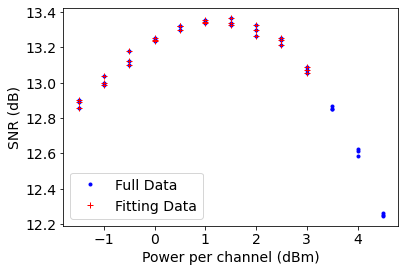

In [3]:
snr_fit = snr[:-9].reshape(-1,1)
pch_fit = pch[:-9].reshape(-1,1)
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_fit, snr_fit, 'r+', label='Fitting Data')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

In [195]:
class simple_model:
    def __init__(self, a=1.0, b=1.0, c=1.0, sigma=1.0):
        self.a = a
        self.b = b
        self.c = c
        self.sigma = sigma
    
    def convert_to_lin(self, x):
        return 10**(x/10)
    
    def convert_to_db(self, x):
        return 10*np.log10(x)
    
    def obj_func(self, params, p_in, y):
        num_pch = len(p_in)
        #np.random.seed(101)
        #[a, b, c, sigma] = params
        [a, b] = params
        return sum((y -  ( p_in/(a + b*p_in**3)))**2)
        #return sum((y -  ( p_in/(a + b*p_in**3) + c*normal(0,sigma,39) ))**2)
    
    def fit(self, p_in, y):  
        p_in = 1e-3*self.convert_to_lin(p_in) # W
        y = self.convert_to_lin(snr)
        #params = np.ndarray(shape=(4,), dtype=float, buffer=np.array([self.a, self.b, self.c, self.sigma]))
        params = np.ndarray(shape=(2,), dtype=float, buffer=np.array([self.a, self.b]))
        opt_res = minimize(self.obj_func,params,args=(p_in, y),method = 'L-BFGS-B',options={'maxiter':1e4})
        return opt_res
    
    def snr_predict(self, p_in, a, b):
        return p_in/(a + b*p_in**3) 
        

In [196]:
sim_model = simple_model()

In [197]:
len(pch)

39

In [198]:
opt_vals = sim_model.fit(pch, snr)

In [199]:
opt_vals.x

array([0.07407408, 1.        ])

Strange bug: optimizer will only work when using normal with a dimension of one (i.e. as an added float) and not when an array of random values is used...

In [201]:
snr_sim = sim_model.snr_predict(pch, opt_vals.x[0], opt_vals.x[1])

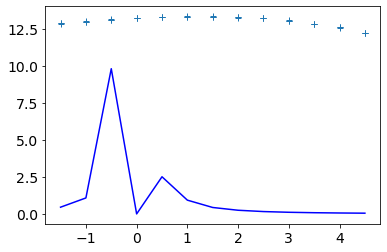

In [202]:
plt.plot(pch, snr, '+')
plt.plot(pch, snr_sim, 'b-')
plt.show()

In [170]:
def obj_func(params, p_in, y):
        [a, b, c, sigma] = params
        #return sum((y - (a + b*p_in**3))**2)**0.5
        #return sum((y - (p_in/(a + b*p_in**3) + c*normal(0, sigma, len(p_in))))**2)
        return y -  ( p_in/(a + b*p_in**3) + c*normal(0,sigma,39) ) 

In [171]:
params = np.ndarray(shape=(4,), dtype=float, buffer=np.array([5,6, 0.1 ,0.1]))
obj_func(params, pch_lin, snr_lin)

array([19.50208281, 19.44580454, 19.30750758, 19.8861519 , 20.13445198,
       19.95590795, 20.5277737 , 20.81802549, 20.40592903, 21.07742865,
       21.15551095, 21.07357569, 21.48038491, 21.50167876, 21.36491704,
       21.57195914, 21.64776826, 21.58099124, 21.50396536, 21.7002796 ,
       21.56503388, 21.23696238, 21.51946559, 21.38769322, 21.10527053,
       20.96551336, 21.16135517, 20.3699984 , 20.21877791, 20.29075498,
       19.3451706 , 19.28460912, 19.27707318, 18.25828824, 18.29446269,
       18.13794374, 16.77158344, 16.76712867, 16.80645789])

In [121]:
np.ndarray(shape=(4,), dtype=float, buffer=np.array([1.0, 1.0, 1.0, 1.0]))

array([1., 1., 1., 1.])